In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"","key":""}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c humpback-whale-identification

  0% 0.00/498k [00:00<?, ?B/s]
100% 498k/498k [00:00<00:00, 76.2MB/s]
  0% 0.00/594k [00:00<?, ?B/s]
100% 594k/594k [00:00<00:00, 82.0MB/s]
100% 1.34G/1.35G [00:14<00:00, 97.5MB/s]
100% 1.35G/1.35G [00:14<00:00, 101MB/s] 
100% 4.14G/4.16G [00:36<00:00, 176MB/s]
100% 4.16G/4.16G [00:36<00:00, 122MB/s]


In [0]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd

In [0]:
from zipfile import ZipFile
# Create a ZipFile Object and load sample.zip in it
with ZipFile('train.zip', 'r') as zipObj:
  # Extract all the contents of zip file in different directory
  zipObj.extractall('data/train')

In [0]:
TRAIN ="train"
TEST = "test"
LABELS = "train.csv"
SUB = "sample_submission.csv"

def text2number(LABELS):
    df = pd.read_csv(LABELS)
    
    uni_labels = pd.DataFrame(df['Id'].unique(),columns=['Id'])
    uni_labels.index.name = 'ID_new'
    uni_labels = uni_labels.reset_index()


    df = df.merge(uni_labels,on='Id')
    
    return df
    
#submit = [p for _, p, _ in pd.read_csv(SUB).to_records()]
#join = list(tagged.keys()) + submit
df = text2number(LABELS)
df.head()

,Image,Id,ID_new
0,0000e88ab.jpg,w_f48451c,0
1,0af805558.jpg,w_f48451c,0
2,1c351b88e.jpg,w_f48451c,0
3,6f7abb1be.jpg,w_f48451c,0
4,77a44bf94.jpg,w_f48451c,0


In [0]:
tagged = dict([(p, w) for _, p,_, w in df.to_records()])
tagged.items()

dict_items([('0000e88ab.jpg', 0), ('0af805558.jpg', 0), ('1c351b88e.jpg', 0), ('6f7abb1be.jpg', 0), ('77a44bf94.jpg', 0), ('79c77838d.jpg', 0), ('9064d5875.jpg', 0), ('9fc84d2ae.jpg', 0), ('c1ec12eb6.jpg', 0), ('c64e5e861.jpg', 0), ('c9df69a69.jpg', 0), ('db0699767.jpg', 0), ('e2f1b6c4a.jpg', 0), ('e3f2dbd25.jpg', 0), ('0001f9222.jpg', 1), ('1d6ccd05a.jpg', 1), ('2cccac55a.jpg', 1), ('cad8eabe4.jpg', 1), ('00029d126.jpg', 2), ('94e15dfd2.jpg', 2), ('a6766b182.jpg', 2), ('d5098b5a1.jpg', 2), ('00050a15a.jpg', 3), ('0005c1ef8.jpg', 3), ('0006e997e.jpg', 3), ('000f0f2bf.jpg', 3), ('001d7450c.jpg', 3), ('00200e115.jpg', 3), ('00245a598.jpg', 3), ('002b4615d.jpg', 3), ('002f99f01.jpg', 3), ('003795857.jpg', 3), ('0041880bf.jpg', 3), ('0043da555.jpg', 3), ('00464ff65.jpg', 3), ('004ae9e26.jpg', 3), ('004c0f43b.jpg', 3), ('005ce3100.jpg', 3), ('00600ce17.jpg', 3), ('006506edf.jpg', 3), ('006bdc6ff.jpg', 3), ('007218187.jpg', 3), ('0085064af.jpg', 3), ('0085a6bd0.jpg', 3), ('00869b59e.jpg', 3)

**Image Augmentation - Method 2**

In [0]:
# Find fluke pics of whales that have less than 10 pics in training data

TRAIN ="data/train"
LABELS = "train.csv"

train = pd.read_csv(LABELS)
train_count = train.groupby('Id').count().rename(columns={"Image":"image_count"})
train = train.merge(train_count,on=['Id'])
filelist = train['Image'].loc[(train['image_count']<5)].tolist()
filelist[:5]

['0001f9222.jpg',
 '1d6ccd05a.jpg',
 '2cccac55a.jpg',
 'cad8eabe4.jpg',
 '00029d126.jpg']

In [0]:
# Generate 10 new pics from original pics

from PIL import ImageFilter
from PIL import Image
from time import time

path = "data/train"

t=time()
tagged_new = tagged.copy() # to store image name and numeric class of orginal images + augmented images

for imagefile in filelist:
    fn = os.path.join(path, imagefile)
    class_num = tagged[imagefile]
    im=Image.open(fn)
    im=im.convert("RGB")
    r,g,b=im.split()
    r=r.convert("RGB")
    g=g.convert("RGB")
    b=b.convert("RGB")
    im_blur=im.filter(ImageFilter.GaussianBlur)
    im_unsharp=im.filter(ImageFilter.UnsharpMask)

    # Save augmented copy of each of the images each as R/B& G
    r.save(os.path.join(path,'r_'+imagefile))
    g.save(os.path.join(path,'g_'+imagefile))
    b.save(os.path.join(path,'b_'+imagefile))  
    # Save augmented copy of each image which is blury
    im_blur.save(os.path.join(path,'bl_'+imagefile))
    # Save augmented copy of each image which is unsharp
    im_unsharp.save(os.path.join(path,'un_'+imagefile))
   
    tagged_new[os.path.join('r_'+imagefile)] = class_num
    tagged_new[os.path.join('g_'+imagefile)] = class_num
    tagged_new[os.path.join('b_'+imagefile)] = class_num
    tagged_new[os.path.join('bl_'+imagefile)] = class_num
    tagged_new[os.path.join('un_'+imagefile)] = class_num

print(time() -t )


1192.049137353897


**Model**

In [0]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow


from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model

import keras.backend as K
from keras.models import Sequential

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [0]:
# run this chunk only when augmented data is used
df_new = pd.DataFrame({'Image':list(tagged_new.keys()),
                       'ID_new':list(tagged_new.values())})
df_new = df_new.merge(df[['ID_new','Id']].drop_duplicates(),how='left',on='ID_new')
print(len(df_new))
df_new.head()

62556


,Image,ID_new,Id
0,0000e88ab.jpg,0,w_f48451c
1,0af805558.jpg,0,w_f48451c
2,1c351b88e.jpg,0,w_f48451c
3,6f7abb1be.jpg,0,w_f48451c
4,77a44bf94.jpg,0,w_f48451c


In [0]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc, ndimage
import keras
from keras import backend as k
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
from time import time

PATH = 'data/train'
BATCH = 32
IMG_SIZE = 224

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale = 1./255)

train_generator = train_datagen.flow_from_dataframe(df_new, # change this to df_new when using augmented data
                                                    directory=PATH,
                                                    x_col='Image',
                                                    y_col='Id',
                                                    class_mode='categorical',
                                                 #   color_mode='grayscale',
                                                    target_size=(IMG_SIZE,IMG_SIZE),
                                                    batch_size=BATCH,
                                                    subset="training",
                                                    shuffle=True
                                                   )

valid_generator = train_datagen.flow_from_dataframe(df_new,
                                                    directory=PATH,
                                                    x_col='Image',
                                                    y_col='Id',
                                                    class_mode='categorical',
                                                 #   color_mode='grayscale',
                                                    target_size=(IMG_SIZE,IMG_SIZE),
                                                    batch_size=BATCH,
                                                    subset="validation",
                                                    shuffle=True
                                                   )


STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)


Found 50045 validated image filenames belonging to 5005 classes.
Found 12511 validated image filenames belonging to 5005 classes.
Total number of batches = 1563 and 390


**ResNet**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.callbacks import *
from keras.initializers import *
from keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1)

# Load pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = True


# get class size
n_classes = 5005

# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = Activation('relu')(X)
X = BatchNormalization()(X)


output = Dense(n_classes, activation='softmax')(X)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step



In [0]:
from keras.callbacks import CSVLogger
from time import time

model3 = Model(inputs=base_model.input, outputs=output)
optimizer = Adam(lr=0.0001)
model3.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy', 'top_k_categorical_accuracy'])

n_epoch = 50

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')


csv_logger = CSVLogger("resnet_aug2.csv", append=True)


t = time()
history3 = model3.fit_generator(
        train_generator,
        steps_per_epoch=1600,
        shuffle=True,
        verbose=1,
        callbacks=[reduce_lr, csv_logger],
        use_multiprocessing=True,
        epochs=15,
        validation_data=valid_generator,
        validation_steps=390)
print(time()-t)

Epoch 1/15
Epoch 1/15
1563/1600 [============================>.] - ETA: 12s - loss: 2.0489 - acc: 0.9193 - top_k_categorical_accuracy: 0.9392Epoch 1/15
Epoch 1/15
1600/1600 [==============================] - 659s 412ms/step - loss: 2.0130 - acc: 0.9210 - top_k_categorical_accuracy: 0.9405 - val_loss: 8.7535 - val_acc: 0.0352 - val_top_k_categorical_accuracy: 0.0352
Epoch 2/15
Epoch 2/15
1600/1600 [==============================] - 646s 404ms/step - loss: 0.2916 - acc: 0.9973 - top_k_categorical_accuracy: 0.9993 - val_loss: 9.1802 - val_acc: 0.0349 - val_top_k_categorical_accuracy: 0.0349
Epoch 3/15
Epoch 3/15
1600/1600 [==============================] - 641s 400ms/step - loss: 0.0279 - acc: 1.0000 - top_k_categorical_accuracy: 1.0000 - val_loss: 9.3812 - val_acc: 0.0357 - val_top_k_categorical_accuracy: 0.0357
Epoch 4/15
Epoch 4/15
1600/1600 [==============================] - 652s 408ms/step - loss: 0.0059 - acc: 0.9999 - top_k_categorical_accuracy: 1.0000 - val_loss: 9.4260 - val_acc:

In [0]:
from keras.callbacks import CSVLogger
from time import time


model3.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy', 'top_k_categorical_accuracy'])

n_epoch = 50

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')


csv_logger = CSVLogger("Resnet_history_artists_200_log.csv", append=True)


t = time()
history3 = model3.fit_generator(
        train_generator,
        steps_per_epoch=1600,
        shuffle=True,
        verbose=1,
        callbacks=[reduce_lr, csv_logger],
        use_multiprocessing=True,
        epochs=15,
        validation_data=valid_generator,
        validation_steps=390)
print(time()-t)

Epoch 1/15
Epoch 1/15
1563/1600 [============================>.] - ETA: 12s - loss: 2.0489 - acc: 0.9193 - top_k_categorical_accuracy: 0.9392Epoch 1/15
Epoch 1/15
1600/1600 [==============================] - 659s 412ms/step - loss: 2.0130 - acc: 0.9210 - top_k_categorical_accuracy: 0.9405 - val_loss: 8.7535 - val_acc: 0.0352 - val_top_k_categorical_accuracy: 0.0352
Epoch 2/15
Epoch 2/15
1600/1600 [==============================] - 646s 404ms/step - loss: 0.2916 - acc: 0.9973 - top_k_categorical_accuracy: 0.9993 - val_loss: 9.1802 - val_acc: 0.0349 - val_top_k_categorical_accuracy: 0.0349
Epoch 3/15
Epoch 3/15
1600/1600 [==============================] - 641s 400ms/step - loss: 0.0279 - acc: 1.0000 - top_k_categorical_accuracy: 1.0000 - val_loss: 9.3812 - val_acc: 0.0357 - val_top_k_categorical_accuracy: 0.0357
Epoch 4/15
Epoch 4/15
1600/1600 [==============================] - 652s 408ms/step - loss: 0.0059 - acc: 0.9999 - top_k_categorical_accuracy: 1.0000 - val_loss: 9.4260 - val_acc:

0.035980447
0.0256241245777375


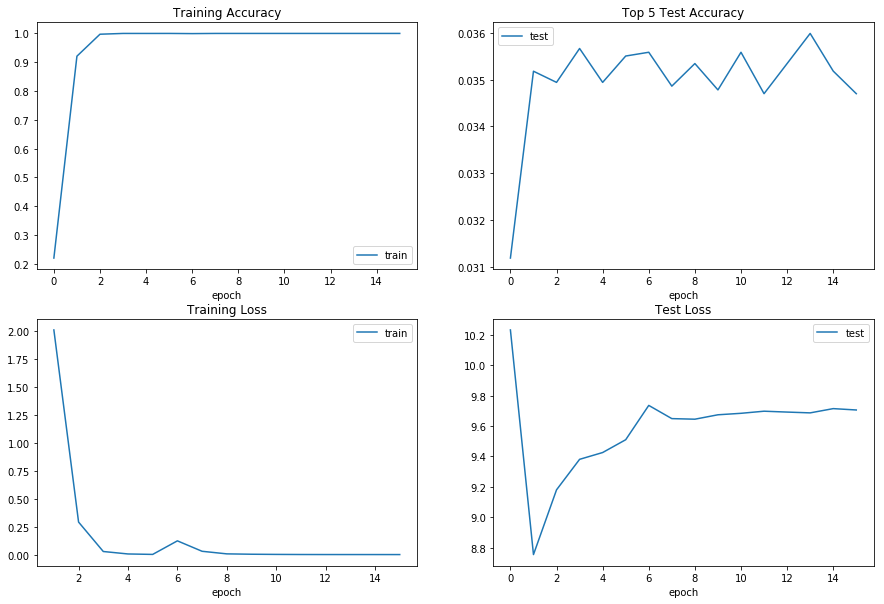

In [7]:
resnet = pd.read_csv('resnet_aug2.csv')

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(resnet['acc'], label='train')
plt.legend()
plt.xlabel('epoch')
plt.title('Training Accuracy')
plt.subplot(2,2,3)
plt.plot(resnet['loss'], label='train')
plt.legend()
plt.xlabel('epoch')
plt.title('Training Loss')
plt.subplot(2,2,2)
plt.plot(resnet['val_top_k_categorical_accuracy'],label='test')
plt.legend()
plt.xlabel('epoch')
plt.title('Top 5 Test Accuracy')
plt.subplot(2,2,4)
plt.plot(resnet['val_loss'], label='test')
plt.legend()
plt.xlabel('epoch')
plt.title('Test Loss')

print(resnet['val_acc'].max())

resnet1 =  pd.read_csv('resnet_aug2.csv')
print(resnet1['val_acc'].max())